<a href="https://colab.research.google.com/github/Gracia123/Sales-Prediction/blob/main/CS680_A5_part_1_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the data

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2020-11-08 21:39:05--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.34.63, 99.86.34.23, 99.86.34.116, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.34.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2020-11-08 21:39:05 (37.4 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.t

In [ ]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Portuguese.txt', 'data/names/Irish.txt', 'data/names/Greek.txt', 'data/names/German.txt', 'data/names/Japanese.txt', 'data/names/Arabic.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/Vietnamese.txt', 'data/names/Czech.txt', 'data/names/Spanish.txt', 'data/names/Chinese.txt', 'data/names/French.txt', 'data/names/Polish.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/Russian.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [ ]:
print(category_lines['Italian'][:5])

['De filippis', 'Spano', 'Tamaro', 'Biondi', 'Palladino']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [ ]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)     

# GRU

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        # self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2h = nn.GRUCell(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
gru = GRU(n_letters, n_hidden, n_categories)

# LSTM

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.LSTMCell(input_size + hidden_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        combined = torch.cat((input, hidden), 1)
        combined_hidden = torch.cat((input, hidden, cell), 1)
        hidden, cell = self.i2h(combined_hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
      
    def initCell(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [ ]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

#GRU
input_1 = letterToTensor('A')
hidden_1 =torch.zeros(1, n_hidden)
output_1, next_hidden1 = gru(input_1, hidden_1)

#LSTM
input_2 = letterToTensor('A')
hidden_2 =torch.zeros(1, n_hidden)
cell = torch.zeros(1, n_hidden)
output_2, next_hidden_2, cell = lstm(input_2, hidden_2, cell)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

#GRU
input_1 = lineToTensor('Albert')
hidden_1 = torch.zeros(1, n_hidden)
output_1, next_hidden_1 = gru(input_1[0], hidden_1)
print(output_1)

#LSTM
input_2 = lineToTensor('Albert')
hidden_2 = torch.zeros(1, n_hidden)
output_2, next_hidden_2, cell = lstm(input_2[0], hidden_2, cell)
print(output_2)

tensor([[-2.9417, -2.9094, -2.8244, -2.8962, -2.9086, -2.8835, -2.9759, -2.8877,
         -2.9060, -2.8420, -2.8758, -2.8143, -2.9328, -2.9022, -2.7959, -2.8699,
         -2.9494, -2.9311]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9958, -2.9221, -2.8761, -2.9762, -2.8484, -2.9005, -2.8409, -2.8093,
         -2.8638, -2.8224, -2.9667, -2.9074, -2.9086, -2.8626, -2.8266, -2.8809,
         -2.8990, -2.9444]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9185, -2.9345, -2.8246, -2.9147, -2.8154, -2.9730, -3.0251, -2.8160,
         -2.9182, -2.7976, -2.8795, -2.9111, -2.7975, -2.8425, -2.9325, -2.9712,
         -2.9440, -2.8493]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 14)


We will also want a quick way to get a training example (a name and its
language):




In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Cashmore
category = Polish / line = Miazga
category = French / line = Fournier
category = Polish / line = Bosko
category = Czech / line = Cvacek
category = Italian / line = Traversini
category = Greek / line = Danas
category = Korean / line = Sun
category = German / line = Beckert
category = Dutch / line = Schoorel


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [ ]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [ ]:
optimizer = torch.optim.Adam(rnn.parameters())
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    loss.backward()

    optimizer.step()

    return output, loss.item()

#GRU

optimizer_1 = torch.optim.Adam(gru.parameters())
def train_gru(category_tensor, line_tensor):
    hidden = gru.initHidden()

    gru.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    loss.backward()

    optimizer_1.step()

    return output, loss.item()

#LSTM

optimizer_2 = torch.optim.Adam(lstm.parameters())
def train_lstm(category_tensor, line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initCell()

    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)
    loss = criterion(output, category_tensor)

    loss.backward()

    optimizer_2.step()

    return output, loss.item()


Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [ ]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss = 0
all_train_losses = []
all_validation_losses = []
all_validation_losses2 = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_lin(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

def eval_dataset_lin(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_lin(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    train_loss += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset_lin(validation_data)

        # save model with best validation loss
        if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
            torch.save(rnn, 'char_rnn_classification_model.pt')
        all_validation_losses.append(average_validation_loss)



Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 19s) 	1.9028 		Riedel / German ✗ (Czech)
10000 	12% 	(0m 41s) 	1.5832 		Wilson / Scottish ✓
15000 	18% 	(1m 1s) 	1.4855 		Durant / French ✓
20000 	25% 	(1m 21s) 	1.4177 		Bahvalov / Russian ✓
25000 	31% 	(1m 41s) 	1.3591 		Albert / German ✗ (Spanish)
30000 	37% 	(2m 0s) 	1.3171 		Doan / Vietnamese ✓
35000 	43% 	(2m 20s) 	1.2875 		Iitaka / Japanese ✓
40000 	50% 	(2m 39s) 	1.2196 		Wang / Korean ✗ (Chinese)
45000 	56% 	(2m 58s) 	1.1658 		Telis / Greek ✓
50000 	62% 	(3m 20s) 	1.1840 		Mushashibo / Japanese ✓
55000 	68% 	(3m 39s) 	1.1452 		Ta / Vietnamese ✓
60000 	75% 	(3m 58s) 	1.0841 		Katsourinis / Greek ✓
65000 	81% 	(4m 19s) 	1.1409 		Camfrlova / Czech ✓
70000 	87% 	(4m 39s) 	1.1231 		Hofler / German ✓
75000 	93% 	(4m 58s) 	1.1089 		Majewski / Polish ✓
80000 	100% 	(5m 18s) 	1.1203 		Paredes / Portuguese ✓


In [ ]:
# GRU

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_1 = 0
all_train_losses_1 = []
all_validation_losses_1 = []
all_validation_losses2_1 = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_gru(line_tensor):
    hidden = gru.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
    return output

def eval_dataset_gru(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_gru(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_gru(category_tensor, line_tensor)
    train_loss_1 += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_1 / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_1.append(train_loss_1 / plot_every)
        train_loss_1 = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset_gru(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_1) == 0 or average_validation_loss < min(all_validation_losses_1):
            torch.save(gru, 'char_gru_classification_model.pt')
        all_validation_losses_1.append(average_validation_loss)



Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 44s) 	1.7457 		Albrici / Italian ✓
10000 	12% 	(1m 32s) 	1.3650 		Gil / Chinese ✗ (Korean)
15000 	18% 	(2m 19s) 	1.0715 		Fabron / French ✓
20000 	25% 	(3m 7s) 	0.9283 		Rousses / Greek ✓
25000 	31% 	(3m 53s) 	0.8113 		Assen / Dutch ✓
30000 	37% 	(4m 39s) 	0.6442 		Vlach / Czech ✓
35000 	43% 	(5m 26s) 	0.6158 		Tsucgimoto / Japanese ✓
40000 	50% 	(6m 12s) 	0.5951 		D'cruz / Portuguese ✓
45000 	56% 	(6m 58s) 	0.5042 		Basurto / Portuguese ✓
50000 	62% 	(7m 43s) 	0.4302 		Casey / Czech ✗ (Irish)
55000 	68% 	(8m 30s) 	0.4105 		Santos / Spanish ✗ (Portuguese)
60000 	75% 	(9m 17s) 	0.3707 		Emberey / English ✓
65000 	81% 	(10m 3s) 	0.3833 		Raske / German ✓
70000 	87% 	(10m 48s) 	0.3976 		Ruvelas / Greek ✓
75000 	93% 	(11m 34s) 	0.3566 		Chandler / German ✗ (English)
80000 	100% 	(12m 21s) 	0.2567 		Matejka / Czech ✓


In [ ]:
# LSTM

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_2 = 0
all_train_losses_2 = []
all_validation_losses_2 = []
all_validation_losses2_2 = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_lstm(line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initCell()
    for i in range(line_tensor.size()[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)
    return output

def eval_dataset_lstm(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_lstm(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_lstm(category_tensor, line_tensor)
    train_loss_2 += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_2 / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_2.append(train_loss_2 / plot_every)
        train_loss_2 = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset_lstm(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_2) == 0 or average_validation_loss < min(all_validation_losses_2):
            torch.save(lstm, 'char_lstm_classification_model.pt')
        all_validation_losses_2.append(average_validation_loss)



Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 49s) 	1.9580 		Yim / Korean ✗ (Chinese)
10000 	12% 	(1m 45s) 	1.4369 		Maalouf / Arabic ✓
15000 	18% 	(2m 41s) 	1.1312 		Hajkova / Czech ✓
20000 	25% 	(3m 36s) 	0.9642 		Boyle / Scottish ✓
25000 	31% 	(4m 31s) 	0.8416 		Yang / Korean ✓
30000 	37% 	(5m 26s) 	0.7632 		Yu / Korean ✓
35000 	43% 	(6m 21s) 	0.6894 		Moralez / Spanish ✓
40000 	50% 	(7m 16s) 	0.5917 		Thi / Vietnamese ✓
45000 	56% 	(8m 12s) 	0.6039 		Mooren / Dutch ✓
50000 	62% 	(9m 7s) 	0.5371 		Beaulieu / French ✓
55000 	68% 	(10m 3s) 	0.4932 		Papadopulos / Greek ✓
60000 	75% 	(10m 59s) 	0.5307 		Gianakopulos / Greek ✓
65000 	81% 	(11m 55s) 	0.5056 		Zogby / Arabic ✓
70000 	87% 	(12m 50s) 	0.4286 		Sutherland / Scottish ✓
75000 	93% 	(13m 45s) 	0.3918 		Hunter / German ✗ (English)
80000 	100% 	(14m 39s) 	0.4691 		Mohan / Irish ✓


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




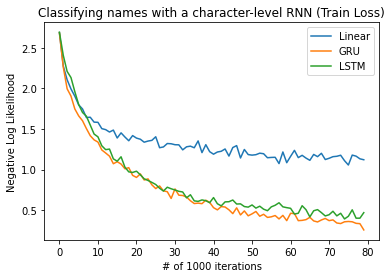

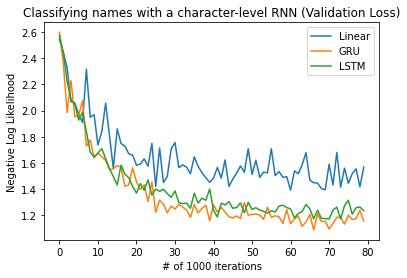

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses)
plt.plot(all_train_losses_1)
plt.plot(all_train_losses_2)
plt.title('Classifying names with a character-level RNN (Train Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear','GRU','LSTM'], loc='upper right')


plt.figure()
plt.plot(all_validation_losses)
plt.plot(all_validation_losses_1)
plt.plot(all_validation_losses_2)
plt.title('Classifying names with a character-level RNN (Validation Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear','GRU','LSTM'], loc='upper right')

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




Average test loss: 1.3110742057335054


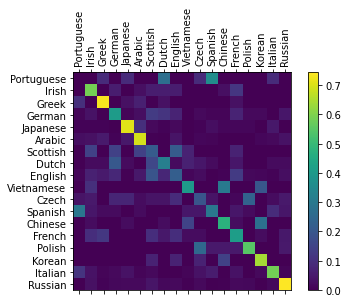

In [ ]:
# Linear
# evaluate on test set and display confusion matrix
rnn = torch.load('char_rnn_classification_model.pt')
average_test_loss, confusion = eval_dataset_lin(test_data)
print('Average test loss: ' + str(average_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Average test loss: 1.0584782286112961


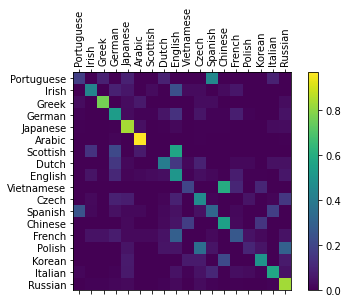

In [ ]:
# GRU
# evaluate on test set and display confusion matrix
gru = torch.load('char_gru_classification_model.pt')
average_test_loss, confusion = eval_dataset_gru(test_data)
print('Average test loss: ' + str(average_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Average test loss: 1.1153523369814229


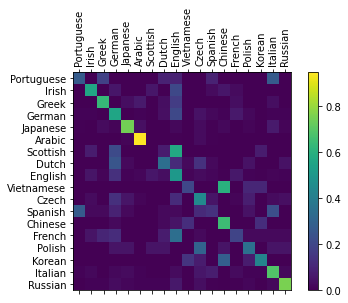

In [ ]:
# LSTM
# evaluate on test set and display confusion matrix
lstm = torch.load('char_lstm_classification_model.pt')
average_test_loss, confusion = eval_dataset_lstm(test_data)
print('Average test loss: ' + str(average_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Running on User Input
---------------------




In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate_lin(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.13) Russian
(-2.41) Czech
(-3.83) English

> Jackson
(-0.81) Russian
(-1.11) English
(-2.55) French

> Satoshi
(-0.86) Japanese
(-1.49) Italian
(-1.87) Arabic


In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate_gru(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.04) Russian
(-3.29) Czech
(-6.23) English

> Jackson
(-0.01) Scottish
(-4.41) English
(-9.31) German

> Satoshi
(-0.08) Japanese
(-3.39) Arabic
(-4.15) Russian


In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate_lstm(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.04) Russian
(-3.89) English
(-4.23) Polish

> Jackson
(-0.60) Scottish
(-0.99) English
(-3.05) Czech

> Satoshi
(-0.09) Japanese
(-2.99) Italian
(-3.72) Arabic
